In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import requests
import time
import pickle
import json
import geopandas as geopd
import pycountry as pc
import pycountry_convert as pc_conv
import folium

def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i, y[i]//2, y[i], ha = 'center')

In [6]:
filenames = ["2015_heat_wave_filtered_csv.bz2", "2015_heat_wave_climate_filtered_csv.bz2",
"2019_heat_wave_filtered_csv.bz2", "2019_heat_wave_climate_filtered_csv.bz2",
"2017_storm_filtered_csv.bz2", "2017_storm_climate_filtered_csv.bz2",
"2019_storm_filtered_csv.bz2", "2019_storm_climate_filtered_csv.bz2"]


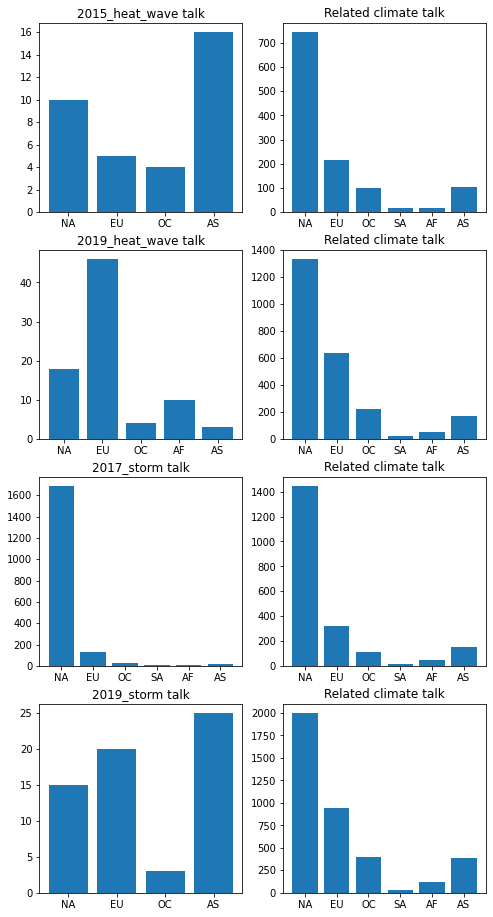

In [13]:
plt.figure(figsize = (8,16))
i=1

for filename in filenames:
    with open('../extracted_country_counts/' + filename + '_code_count.json') as json_file:
        dict_code_count = json.load(json_file)
    dict_country_count = {}

    # Load the dictionary <code : country_name>
    with open('country_code_dict.json') as json_file:
        dict_code_country = json.load(json_file)

    for nationality_code in dict_code_count:
        if nationality_code in dict_code_country:
            dict_country_count[dict_code_country[nationality_code]] = dict_code_count[nationality_code]
        else:
            print("Need to fetch :" + nationality_code)
            api_url = "http://www.wikidata.org/entity/" + nationality_code
            response = requests.get(api_url)
            country_name = response.json()['entities'][nationality_code]['labels']['en']['value']
            dict_code_country[nationality_code] = country_name
            dict_country_count[country_name] = dict_code_count[nationality_code]

    with open('country_code_dict.json', 'w') as fp:
        json.dump(dict_code_country, fp)

    non_recognized = []
    dict_continent_count = {}

    for element in dict_country_count:
        try:
            continent_code = pc_conv.country_alpha2_to_continent_code(pc_conv.country_name_to_country_alpha2(element, cn_name_format="default"))
            if continent_code in dict_continent_count:
                dict_continent_count[continent_code] += dict_country_count[element]
            else :
                dict_continent_count[continent_code] = dict_country_count[element]
        except:
            if element not in non_recognized:
                non_recognized.append(element)
    data = pd.merge(pd.DataFrame({
   'lon':[-100, 8, 135, -57, 20, 90],
   'lat':[50, 49, -25, -13, 0, 55],
   'continent':['NA', 'EU', 'OC', 'SA', 'AF', 'AS']}), 
    pd.DataFrame(dict_continent_count.items(), columns=['continent', 'value']), on = 'continent')

    plt.subplot(4, 2, i)
    plt.bar(data['continent'], data['value'])
    if 'climate' in filename:
        plt.title('Related climate talk')
    else:
        plt.title(filename[:-17] + " talk")
    i += 1

plt.show()